## Tacotron 2 inference code 
Edit the variables **checkpoint_path** and **text** to match yours and run the entire code to generate plots of mel outputs, alignments and audio synthesis from the generated mel-spectrogram using Griffin-Lim.

#### Import libraries and setup matplotlib

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

import IPython.display as ipd

import sys
sys.path.append('waveglow/')
import numpy as np
import torch

%cd '/content/drive/MyDrive/tacotron2'
%ls

import sys
sys.path.insert(0,'/content/drive/MyDrive/tacotron2')
print(sys.path)

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence
from denoiser import Denoiser

/content/drive/MyDrive/tacotron2
 apex/                  layers.py           requirements.txt
 audio_processing.py    LICENSE             stft.py
'data_utils (1).py'     logger.py           tacotron2_statedict.pt
 data_utils.py          loss_function.py    tensorboard.png
 demo.wav               loss_scaler.py      text/
 distributed.py         model.py            trainedhappy.pth
 Dockerfile             multiproc.py        train.py
 filelists/             outdir/             Untitled0.ipynb
 happy@                 plotting_utils.py   utils.py
 hparams.py             __pycache__/        waveglow/
'inference (1).ipynb'   README.md           waveglow_256channels.pt
 inference.ipynb        requirements.gdoc
['/content/drive/MyDrive/tacotron2', '/content/drive/MyDrive/tacotron2', '/content/drive/MyDrive/tacotron2', '/content', '/env/python', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/usr/local/lib/python3.8/dist-packages', '/usr/lib/python3/dist-

ModuleNotFoundError: ignored

In [4]:
# from train import load_model
from text import text_to_sequence

import sys
sys.path.append('tacotron2')
import torch
from layers import STFT


class Denoiser(torch.nn.Module):
    """ Removes model bias from audio produced with waveglow """

    def __init__(self, waveglow, filter_length=1024, n_overlap=4,
                 win_length=1024, mode='zeros'):
        super(Denoiser, self).__init__()
        self.stft = STFT(filter_length=filter_length,
                         hop_length=int(filter_length/n_overlap),
                         win_length=win_length).cuda()
        if mode == 'zeros':
            mel_input = torch.zeros(
                (1, 80, 88),
                dtype=waveglow.upsample.weight.dtype,
                device=waveglow.upsample.weight.device)
        elif mode == 'normal':
            mel_input = torch.randn(
                (1, 80, 88),
                dtype=waveglow.upsample.weight.dtype,
                device=waveglow.upsample.weight.device)
        else:
            raise Exception("Mode {} if not supported".format(mode))

        with torch.no_grad():
            bias_audio = waveglow.infer(mel_input, sigma=0.0).float()
            bias_spec, _ = self.stft.transform(bias_audio)

        self.register_buffer('bias_spec', bias_spec[:, :, 0][:, :, None])

    def forward(self, audio, strength=0.1):
        audio_spec, audio_angles = self.stft.transform(audio.cuda().float())
        audio_spec_denoised = audio_spec - self.bias_spec * strength
        audio_spec_denoised = torch.clamp(audio_spec_denoised, 0.0)
        audio_denoised = self.stft.inverse(audio_spec_denoised, audio_angles)
        return audio_denoised

In [5]:
import torch
import torch.distributed as dist
from torch.nn.modules import Module
from torch.autograd import Variable

def _flatten_dense_tensors(tensors):
    """Flatten dense tensors into a contiguous 1D buffer. Assume tensors are of
    same dense type.
    Since inputs are dense, the resulting tensor will be a concatenated 1D
    buffer. Element-wise operation on this buffer will be equivalent to
    operating individually.
    Arguments:
        tensors (Iterable[Tensor]): dense tensors to flatten.
    Returns:
        A contiguous 1D buffer containing input tensors.
    """
    if len(tensors) == 1:
        return tensors[0].contiguous().view(-1)
    flat = torch.cat([t.contiguous().view(-1) for t in tensors], dim=0)
    return flat

def _unflatten_dense_tensors(flat, tensors):
    """View a flat buffer using the sizes of tensors. Assume that tensors are of
    same dense type, and that flat is given by _flatten_dense_tensors.
    Arguments:
        flat (Tensor): flattened dense tensors to unflatten.
        tensors (Iterable[Tensor]): dense tensors whose sizes will be used to
          unflatten flat.
    Returns:
        Unflattened dense tensors with sizes same as tensors and values from
        flat.
    """
    outputs = []
    offset = 0
    for tensor in tensors:
        numel = tensor.numel()
        outputs.append(flat.narrow(0, offset, numel).view_as(tensor))
        offset += numel
    return tuple(outputs)


'''
This version of DistributedDataParallel is designed to be used in conjunction with the multiproc.py
launcher included with this example. It assumes that your run is using multiprocess with 1
GPU/process, that the model is on the correct device, and that torch.set_device has been
used to set the device.

Parameters are broadcasted to the other processes on initialization of DistributedDataParallel,
and will be allreduced at the finish of the backward pass.
'''
class DistributedDataParallel(Module):

    def __init__(self, module):
        super(DistributedDataParallel, self).__init__()
        #fallback for PyTorch 0.3
        if not hasattr(dist, '_backend'):
            self.warn_on_half = True
        else:
            self.warn_on_half = True if dist._backend == dist.dist_backend.GLOO else False

        self.module = module

        for p in self.module.state_dict().values():
            if not torch.is_tensor(p):
                continue
            dist.broadcast(p, 0)

        def allreduce_params():
            if(self.needs_reduction):
                self.needs_reduction = False
                buckets = {}
                for param in self.module.parameters():
                    if param.requires_grad and param.grad is not None:
                        tp = type(param.data)
                        if tp not in buckets:
                            buckets[tp] = []
                        buckets[tp].append(param)
                if self.warn_on_half:
                    if torch.cuda.HalfTensor in buckets:
                        print("WARNING: gloo dist backend for half parameters may be extremely slow." +
                              " It is recommended to use the NCCL backend in this case. This currently requires" +
                              "PyTorch built from top of tree master.")
                        self.warn_on_half = False

                for tp in buckets:
                    bucket = buckets[tp]
                    grads = [param.grad.data for param in bucket]
                    coalesced = _flatten_dense_tensors(grads)
                    dist.all_reduce(coalesced)
                    coalesced /= dist.get_world_size()
                    for buf, synced in zip(grads, _unflatten_dense_tensors(coalesced, grads)):
                        buf.copy_(synced)

        for param in list(self.module.parameters()):
            def allreduce_hook(*unused):
                param._execution_engine.queue_callback(allreduce_params)
            if param.requires_grad:
                param.register_hook(allreduce_hook)

    def forward(self, *inputs, **kwargs):
        self.needs_reduction = True
        return self.module(*inputs, **kwargs)

    '''
    def _sync_buffers(self):
        buffers = list(self.module._all_buffers())
        if len(buffers) > 0:
            # cross-node buffer sync
            flat_buffers = _flatten_dense_tensors(buffers)
            dist.broadcast(flat_buffers, 0)
            for buf, synced in zip(buffers, _unflatten_dense_tensors(flat_buffers, buffers)):
                buf.copy_(synced)
     def train(self, mode=True):
        # Clear NCCL communicator and CUDA event cache of the default group ID,
        # These cache will be recreated at the later call. This is currently a
        # work-around for a potential NCCL deadlock.
        if dist._backend == dist.dist_backend.NCCL:
            dist._clear_group_cache()
        super(DistributedDataParallel, self).train(mode)
        self.module.train(mode)
    '''
'''
Modifies existing model to do gradient allreduce, but doesn't change class
so you don't need "module"
'''
def apply_gradient_allreduce(module):
        if not hasattr(dist, '_backend'):
            module.warn_on_half = True
        else:
            module.warn_on_half = True if dist._backend == dist.dist_backend.GLOO else False

        for p in module.state_dict().values():
            if not torch.is_tensor(p):
                continue
            dist.broadcast(p, 0)

        def allreduce_params():
            if(module.needs_reduction):
                module.needs_reduction = False
                buckets = {}
                for param in module.parameters():
                    if param.requires_grad and param.grad is not None:
                        tp = param.data.dtype
                        if tp not in buckets:
                            buckets[tp] = []
                        buckets[tp].append(param)
                if module.warn_on_half:
                    if torch.cuda.HalfTensor in buckets:
                        print("WARNING: gloo dist backend for half parameters may be extremely slow." +
                              " It is recommended to use the NCCL backend in this case. This currently requires" +
                              "PyTorch built from top of tree master.")
                        module.warn_on_half = False

                for tp in buckets:
                    bucket = buckets[tp]
                    grads = [param.grad.data for param in bucket]
                    coalesced = _flatten_dense_tensors(grads)
                    dist.all_reduce(coalesced)
                    coalesced /= dist.get_world_size()
                    for buf, synced in zip(grads, _unflatten_dense_tensors(coalesced, grads)):
                        buf.copy_(synced)

        for param in list(module.parameters()):
            def allreduce_hook(*unused):
                Variable._execution_engine.queue_callback(allreduce_params)
            if param.requires_grad:
                param.register_hook(allreduce_hook)

        def set_needs_reduction(self, input, output):
            self.needs_reduction = True

        module.register_forward_hook(set_needs_reduction)
        return module

In [6]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')

#### Setup hparams

In [7]:
hparams = create_hparams()
hparams['sampling_rate'] = 22050

#### Load model from checkpoint

In [8]:
from numpy import finfo

def load_model(hparams):
    model = Tacotron2(hparams).cuda()
    if hparams['fp16_run']:
        model.decoder.attention_layer.score_mask_value = finfo('float16').min

    if hparams['distributed_run']:
        model = apply_gradient_allreduce(model)

    return model

In [9]:
!pip install torch
import torch
torch.version.cuda
torch.cuda.is_available()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


True

In [10]:
checkpoint_path = "tacotron2_statedict.pt"
model = load_model(hparams)
model.load_state_dict(torch.load('/content/drive/MyDrive/tacotron2/'+checkpoint_path)['state_dict'])
_ = model.cuda().eval()

#### Load WaveGlow for mel2audio synthesis and denoiser

In [11]:
sys.path.append('waveglow/')
%cd waveglow/
!git pull origin master


waveglow_path = 'waveglow_256channels.pt'
waveglow = torch.load('/content/drive/MyDrive/tacotron2/' + waveglow_path)['model']
waveglow.cuda().eval()
for k in waveglow.convinv:
    k.float()
denoiser = Denoiser(waveglow)

/content/drive/MyDrive/tacotron2/waveglow
From https://github.com/NVIDIA/waveglow
 * branch            master     -> FETCH_HEAD
Already up to date.


/usr/local/lib/python3.8/dist-packages/torch/serialization.py:868: SourceChangeWarning: source code of class 'torch.nn.modules.conv.ConvTranspose1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.8/dist-packages/torch/serialization.py:868: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.8/dist-packages/torch/serialization.py:868: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv1d' has changed. you can retrieve the original source code by accessing the object's source attribute or

#### Prepare text input

In [12]:
text = "Waveglow is really awesome!"
sequence = np.array(text_to_sequence(text, ['english_cleaners']))[None, :]
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cuda().long()

#### Decode text input and plot results

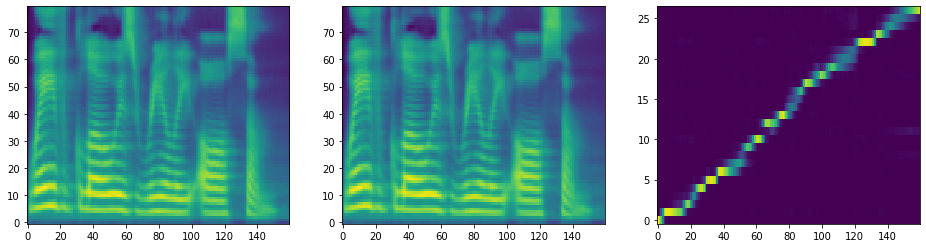

In [13]:
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

#### Synthesize audio from spectrogram using WaveGlow

In [16]:
print(mel_outputs_postnet)

tensor([[[ -7.3086,  -6.6250,  -6.7656,  ...,  -8.2578,  -8.0781,  -7.7383],
         [ -6.8164,  -6.0977,  -5.9141,  ...,  -6.9258,  -6.8320,  -6.6719],
         [ -6.1445,  -5.4297,  -5.1094,  ...,  -5.6094,  -5.6172,  -5.6562],
         ...,
         [-10.3438, -10.1797,  -9.8438,  ...,  -9.2891,  -9.3438,  -9.3594],
         [-10.3828, -10.1797,  -9.7344,  ...,  -9.3359,  -9.3906,  -9.3984],
         [-10.4609, -10.2422,  -9.7031,  ...,  -9.4062,  -9.4297,  -9.4375]]],
       device='cuda:0', dtype=torch.float16, grad_fn=<AddBackward0>)


In [33]:
import copy
import torch
from torch.autograd import Variable
import torch.nn.functional as F


@torch.jit.script
def fused_add_tanh_sigmoid_multiply(input_a, input_b, n_channels):
    n_channels_int = n_channels[0]
    in_act = input_a+input_b
    t_act = torch.tanh(in_act[:, :n_channels_int, :])
    s_act = torch.sigmoid(in_act[:, n_channels_int:, :])
    acts = t_act * s_act
    return acts


class WaveGlowLoss(torch.nn.Module):
    def __init__(self, sigma=1.0):
        super(WaveGlowLoss, self).__init__()
        self.sigma = sigma

    def forward(self, model_output):
        z, log_s_list, log_det_W_list = model_output
        for i, log_s in enumerate(log_s_list):
            if i == 0:
                log_s_total = torch.sum(log_s)
                log_det_W_total = log_det_W_list[i]
            else:
                log_s_total = log_s_total + torch.sum(log_s)
                log_det_W_total += log_det_W_list[i]

        loss = torch.sum(z*z)/(2*self.sigma*self.sigma) - log_s_total - log_det_W_total
        return loss/(z.size(0)*z.size(1)*z.size(2))


class Invertible1x1Conv(torch.nn.Module):
    """
    The layer outputs both the convolution, and the log determinant
    of its weight matrix.  If reverse=True it does convolution with
    inverse
    """
    def __init__(self, c):
        super(Invertible1x1Conv, self).__init__()
        self.conv = torch.nn.Conv1d(c, c, kernel_size=1, stride=1, padding=0,
                                    bias=False)

        # Sample a random orthonormal matrix to initialize weights
        W = torch.qr(torch.FloatTensor(c, c).normal_())[0]

        # Ensure determinant is 1.0 not -1.0
        if torch.det(W) < 0:
            W[:,0] = -1*W[:,0]
        W = W.view(c, c, 1)
        self.conv.weight.data = W

    def forward(self, z, reverse=False):
        # shape
        batch_size, group_size, n_of_groups = z.size()

        W = self.conv.weight.squeeze()

        if reverse:
            if not hasattr(self, 'W_inverse'):
                # Reverse computation
                W_inverse = W.float().inverse()
                W_inverse = Variable(W_inverse[..., None])
                if z.type() == 'torch.cuda.HalfTensor':
                    W_inverse = W_inverse.half()
                self.W_inverse = W_inverse
            z = F.conv1d(z, self.W_inverse, bias=None, stride=1, padding=0)
            return z
        else:
            # Forward computation
            log_det_W = batch_size * n_of_groups * torch.logdet(W)
            z = self.conv(z)
            return z, log_det_W


class WN(torch.nn.Module):
    """
    This is the WaveNet like layer for the affine coupling.  The primary difference
    from WaveNet is the convolutions need not be causal.  There is also no dilation
    size reset.  The dilation only doubles on each layer
    """
    def __init__(self, n_in_channels, n_mel_channels, n_layers, n_channels,
                 kernel_size):
        super(WN, self).__init__()
        assert(kernel_size % 2 == 1)
        assert(n_channels % 2 == 0)
        self.n_layers = n_layers
        self.n_channels = n_channels
        self.in_layers = torch.nn.ModuleList()
        self.res_skip_layers = torch.nn.ModuleList()

        start = torch.nn.Conv1d(n_in_channels, n_channels, 1)
        start = torch.nn.utils.weight_norm(start, name='weight')
        self.start = start

        # Initializing last layer to 0 makes the affine coupling layers
        # do nothing at first.  This helps with training stability
        end = torch.nn.Conv1d(n_channels, 2*n_in_channels, 1)
        end.weight.data.zero_()
        end.bias.data.zero_()
        self.end = end

        cond_layer = torch.nn.Conv1d(n_mel_channels, 2*n_channels*n_layers, 1)
        self.cond_layer = torch.nn.utils.weight_norm(cond_layer, name='weight')

        for i in range(n_layers):
            dilation = 2 ** i
            padding = int((kernel_size*dilation - dilation)/2)
            in_layer = torch.nn.Conv1d(n_channels, 2*n_channels, kernel_size,
                                       dilation=dilation, padding=padding)
            in_layer = torch.nn.utils.weight_norm(in_layer, name='weight')
            self.in_layers.append(in_layer)


            # last one is not necessary
            if i < n_layers - 1:
                res_skip_channels = 2*n_channels
            else:
                res_skip_channels = n_channels
            res_skip_layer = torch.nn.Conv1d(n_channels, res_skip_channels, 1)
            res_skip_layer = torch.nn.utils.weight_norm(res_skip_layer, name='weight')
            self.res_skip_layers.append(res_skip_layer)

    def forward(self, forward_input):
        audio, spect = forward_input
        audio = self.start(audio)
        output = torch.zeros_like(audio)
        n_channels_tensor = torch.IntTensor([self.n_channels])

        spect = self.cond_layer(spect)

        for i in range(self.n_layers):
            spect_offset = i*2*self.n_channels
            acts = fused_add_tanh_sigmoid_multiply(
                self.in_layers[i](audio),
                spect[:,spect_offset:spect_offset+2*self.n_channels,:],
                n_channels_tensor)

            res_skip_acts = self.res_skip_layers[i](acts)
            if i < self.n_layers - 1:
                audio = audio + res_skip_acts[:,:self.n_channels,:]
                output = output + res_skip_acts[:,self.n_channels:,:]
            else:
                output = output + res_skip_acts

        return self.end(output)


class WaveGlow(torch.nn.Module):
    def __init__(self, n_mel_channels, n_flows, n_group, n_early_every,
                 n_early_size, WN_config):
        super(WaveGlow, self).__init__()

        self.upsample = torch.nn.ConvTranspose1d(n_mel_channels,
                                                 n_mel_channels,
                                                 1024, stride=256)
        assert(n_group % 2 == 0)
        self.n_flows = n_flows
        self.n_group = n_group
        self.n_early_every = n_early_every
        self.n_early_size = n_early_size
        self.WN = torch.nn.ModuleList()
        self.convinv = torch.nn.ModuleList()

        n_half = int(n_group/2)

        # Set up layers with the right sizes based on how many dimensions
        # have been output already
        n_remaining_channels = n_group
        for k in range(n_flows):
            if k % self.n_early_every == 0 and k > 0:
                n_half = n_half - int(self.n_early_size/2)
                n_remaining_channels = n_remaining_channels - self.n_early_size
            self.convinv.append(Invertible1x1Conv(n_remaining_channels))
            self.WN.append(WN(n_half, n_mel_channels*n_group, **WN_config))
        self.n_remaining_channels = n_remaining_channels  # Useful during inference

    def forward(self, forward_input):
        """
        forward_input[0] = mel_spectrogram:  batch x n_mel_channels x frames
        forward_input[1] = audio: batch x time
        """
        spect, audio = forward_input

        #  Upsample spectrogram to size of audio
        spect = self.upsample(spect)
        assert(spect.size(2) >= audio.size(1))
        if spect.size(2) > audio.size(1):
            spect = spect[:, :, :audio.size(1)]

        spect = spect.unfold(2, self.n_group, self.n_group).permute(0, 2, 1, 3)
        spect = spect.contiguous().view(spect.size(0), spect.size(1), -1).permute(0, 2, 1)

        audio = audio.unfold(1, self.n_group, self.n_group).permute(0, 2, 1)
        output_audio = []
        log_s_list = []
        log_det_W_list = []

        for k in range(self.n_flows):
            if k % self.n_early_every == 0 and k > 0:
                output_audio.append(audio[:,:self.n_early_size,:])
                audio = audio[:,self.n_early_size:,:]

            audio, log_det_W = self.convinv[k](audio)
            log_det_W_list.append(log_det_W)

            n_half = int(audio.size(1)/2)
            audio_0 = audio[:,:n_half,:]
            audio_1 = audio[:,n_half:,:]

            output = self.WN[k]((audio_0, spect))
            log_s = output[:, n_half:, :]
            b = output[:, :n_half, :]
            audio_1 = torch.exp(log_s)*audio_1 + b
            log_s_list.append(log_s)

            audio = torch.cat([audio_0, audio_1],1)

        output_audio.append(audio)
        return torch.cat(output_audio,1), log_s_list, log_det_W_list

    def infer(self, spect, sigma=1.0):
        spect = self.upsample(spect)
        # trim conv artifacts. maybe pad spec to kernel multiple
        time_cutoff = self.upsample.kernel_size[0] - self.upsample.stride[0]
        spect = spect[:, :, :-time_cutoff]

        spect = spect.unfold(2, self.n_group, self.n_group).permute(0, 2, 1, 3)
        spect = spect.contiguous().view(spect.size(0), spect.size(1), -1).permute(0, 2, 1)

        if spect.type() == 'torch.cuda.HalfTensor':
            audio = torch.cuda.HalfTensor(spect.size(0),
                                          self.n_remaining_channels,
                                          spect.size(2)).normal_()
        else:
            audio = torch.cuda.FloatTensor(spect.size(0),
                                           self.n_remaining_channels,
                                           spect.size(2)).normal_()

        audio = torch.autograd.Variable(sigma*audio)

        for k in reversed(range(self.n_flows)):
            n_half = int(audio.size(1)/2)
            audio_0 = audio[:,:n_half,:]
            audio_1 = audio[:,n_half:,:]

            output = self.WN[k]((audio_0, spect))

            s = output[:, n_half:, :]
            b = output[:, :n_half, :]
            audio_1 = (audio_1 - b)/torch.exp(s)
            audio = torch.cat([audio_0, audio_1],1)

            audio = self.convinv[k](audio, reverse=True)

            if k % self.n_early_every == 0 and k > 0:
                if spect.type() == 'torch.cuda.HalfTensor':
                    z = torch.cuda.HalfTensor(spect.size(0), self.n_early_size, spect.size(2)).normal_()
                else:
                    z = torch.cuda.FloatTensor(spect.size(0), self.n_early_size, spect.size(2)).normal_()
                audio = torch.cat((sigma*z, audio),1)

        audio = audio.permute(0,2,1).contiguous().view(audio.size(0), -1).data
        return audio

    @staticmethod
    def remove_weightnorm(model):
        waveglow = model
        for WN in waveglow.WN:
            WN.start = torch.nn.utils.remove_weight_norm(WN.start)
            WN.in_layers = remove(WN.in_layers)
            WN.cond_layer = torch.nn.utils.remove_weight_norm(WN.cond_layer)
            WN.res_skip_layers = remove(WN.res_skip_layers)
        return waveglow


def remove(conv_list):
    new_conv_list = torch.nn.ModuleList()
    for old_conv in conv_list:
        old_conv = torch.nn.utils.remove_weight_norm(old_conv)
        new_conv_list.append(old_conv)
    return new_conv_list



In [34]:
!pip install tensorflow
import tensorflow as tf
tf.audio.encode_wav(
    mel_outputs_postnet, 22050, name=None
)
with torch.no_grad():
    audio = infer(mel_outputs_postnet, sigma=0.666)
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams['sampling_rate'])

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


TypeError: ignored

#### (Optional) Remove WaveGlow bias

In [ ]:
audio_denoised = denoiser(audio, strength=0.01)[:, 0]
ipd.Audio(audio_denoised.cpu().numpy(), rate=hparams['sampling_rate']) 